# Image classifier for the SVHN dataset
## Overview

In this notebook, I will create a neural network that classifies real-world images digits. I will use concepts from throughout this course in building, training, testing, validating and saving my Tensorflow classifier model.

## Let's get started!

We'll start by running some imports, and loading the dataset.

### Imports and file paths are updated by (amanat)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import shap
from scipy.io import loadmat
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.preprocessing import OneHotEncoder,label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/6f/36/2f5105c5accba2a58a8c6fda8d890fe8de329545f673a4f62235a67d723d/shap-0.44.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
# !python -m pip install --upgrade pip
# !pip install lime
#!pip install pydot

For this project, I will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Load the dataset from your Drive folder

train = loadmat('/Users/tajwar/Desktop/438/train_32x32.mat')
test = loadmat('/Users/tajwar/Desktop/438/test_32x32.mat')

# Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries already loaded.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

In [4]:
###comment by amanat for understanding the code
### images are in array format


In [5]:
# Loading the dataset

x_train = train['X']
x_test = test['X']
y_train = train['y']
y_test = test['y']

In [6]:
# analysing the dimensions of the input
x_train.shape, x_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [7]:
# changing dimensions from (a, b, c, num_examples) to (num_examples, a, b, c)

x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

In [8]:
# checking if dimensions have actually changed

x_train.shape, x_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

### Label correction [only below ] (amanat)

In [9]:
### adding this cell for label correction

y_train[y_train == 10] = 0
y_test[y_test == 10] = 0


In [10]:
# Calculate the total number of images
num_images = x_train.shape[0] + x_test.shape[0]

print("Total Number of Images", num_images)

#x_train = x_train[:,:,:,0]

#x_test = x_test[:,:,:,0]

Total Number of Images 99289


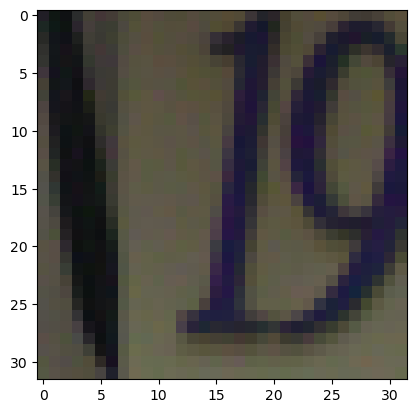

[1]


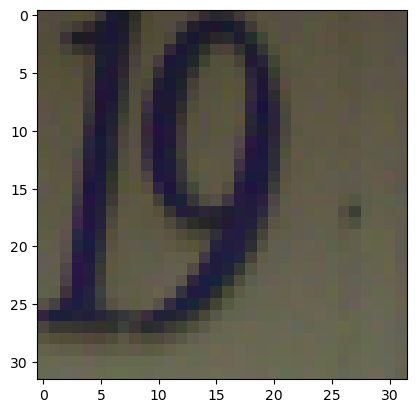

[9]


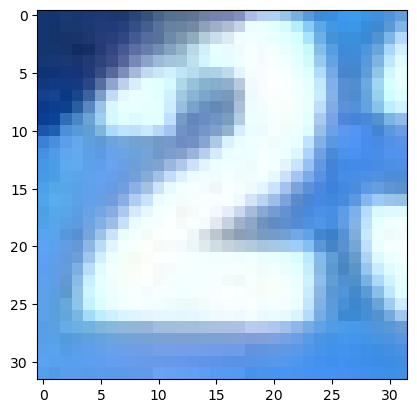

[2]


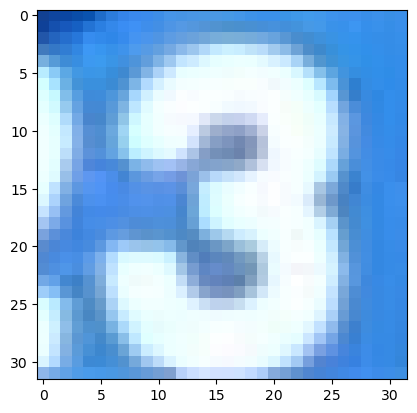

[3]


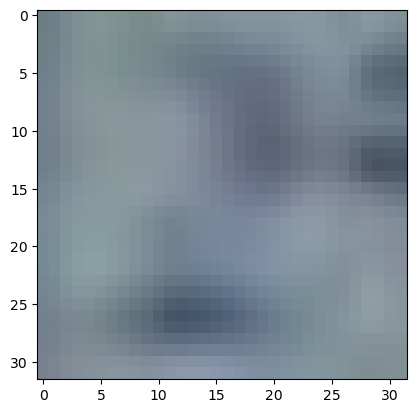

[2]


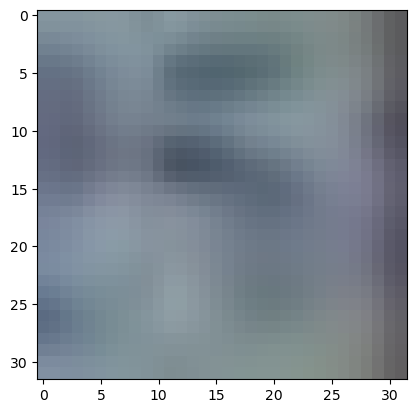

[5]


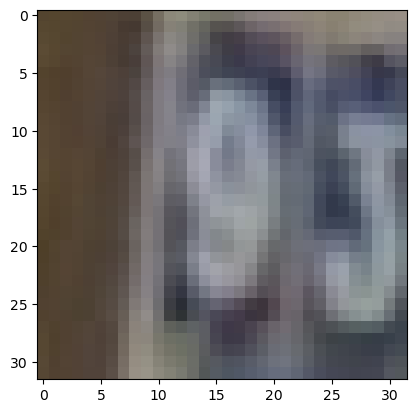

[9]


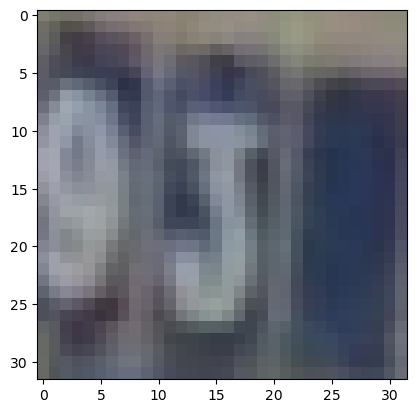

[3]


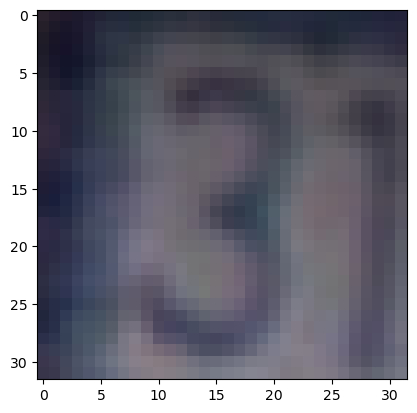

[3]


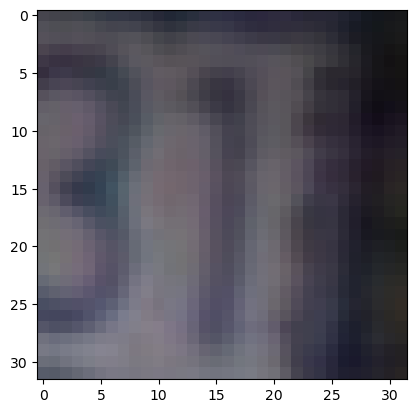

[1]


In [11]:
# plotting some sample images

for i in range(10):
    plt.imshow(x_train[i, :, :, :])
    plt.show()
    print(y_train[i])

In [12]:
# making changes to the images

x_train_gray = np.mean(x_train, 3).reshape(73257, 32, 32, 1) / 255.
x_test_gray = np.mean(x_test, 3).reshape(26032, 32, 32, 1) / 255.
x_train_plot = np.mean(x_train, 3)

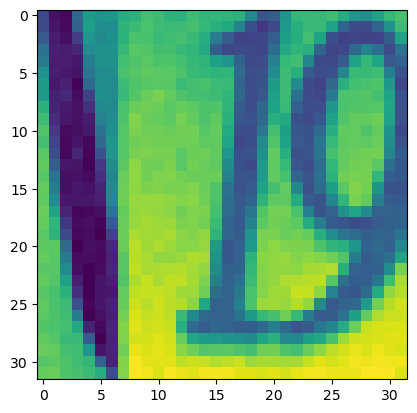

[1]


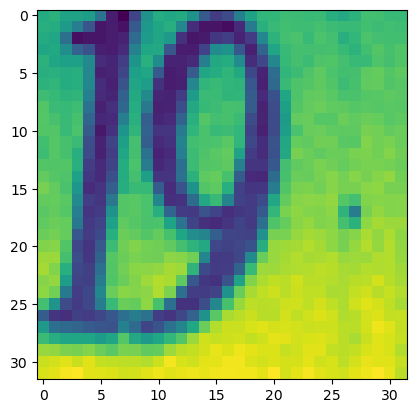

[9]


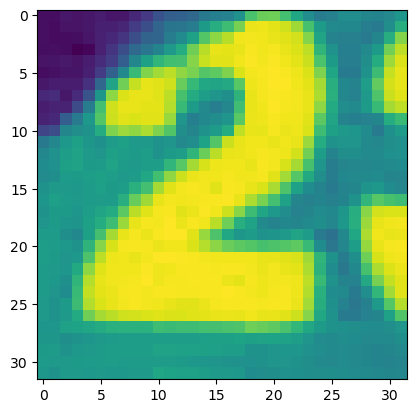

[2]


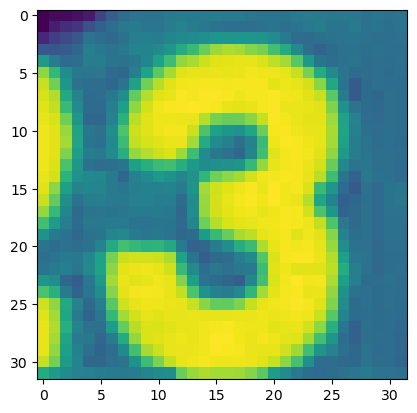

[3]


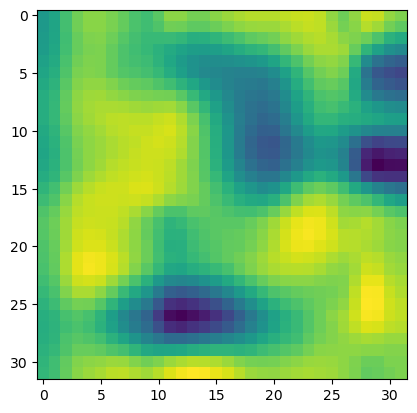

[2]


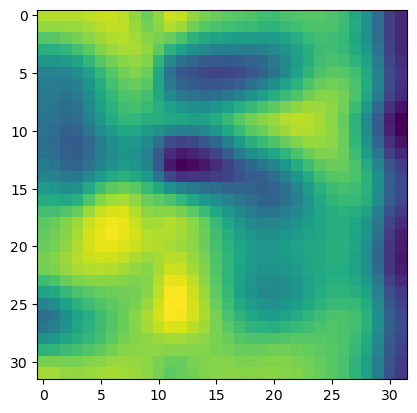

[5]


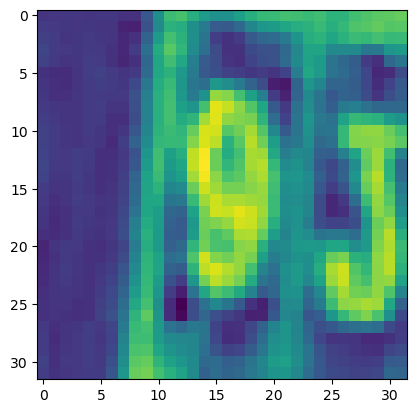

[9]


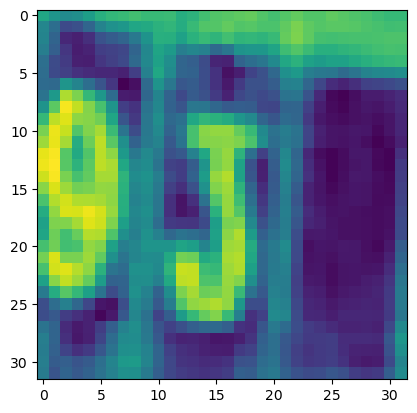

[3]


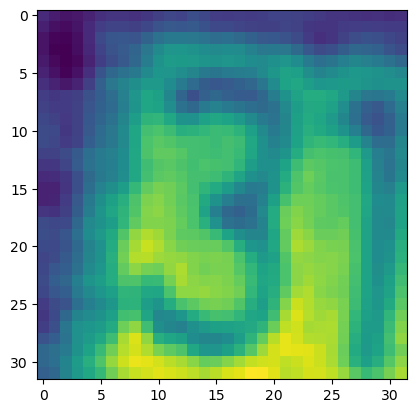

[3]


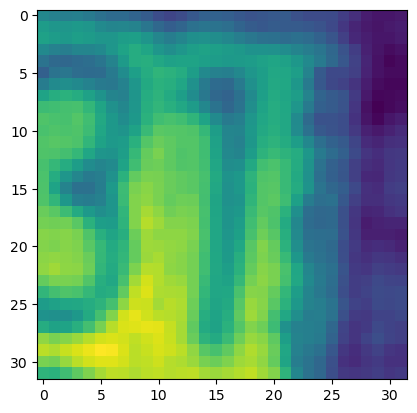

[1]


In [13]:
# plotting the training images

for i in range(10):
    plt.imshow(x_train_plot[i, :, :,])
    plt.show()
    print(y_train[i])

In [14]:
# was having trouble in MLP NN classifier, so converting to one-hot labels

x_train[0].shape

(32, 32, 3)

In [15]:
enc = OneHotEncoder().fit(y_train)
y_train_oh = enc.transform(y_train).toarray()
y_test_oh = enc.transform(y_test).toarray()

In [16]:
y_test_oh[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

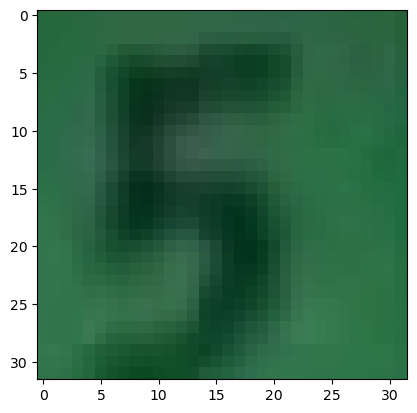

In [17]:

plt.imshow(x_test[0])


# MLP neural network classifier

In [75]:
model_seq = Sequential([
                        Flatten(input_shape=x_train[0].shape),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        BatchNormalization(),
                        Dense(256, activation='relu'),
                        Dropout(0.3),
                        Dense(128, activation='relu'),
                        Dense(10, activation='softmax')

])

model_seq.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               1573376   
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [76]:
model_seq.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
checkpoint = ModelCheckpoint(filepath='sequential',
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

early_stop = EarlyStopping(patience=10, monitor='loss')

In [78]:
# model_seq = Sequential([
#                         Flatten(input_shape=x_train[0].shape),
#                         Dense(128, activation='relu'),
#                         Dense(256, activation='relu'),
#                         BatchNormalization(),
#                         Dense(256, activation='relu'),
#                         Dropout(0.5),
#                         Dense(512, activation='relu'),
#                         Dense(10, activation='softmax')

# ])

# model_seq.summary()

In [79]:
# model_seq.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [80]:
# checkpoint = ModelCheckpoint(filepath='sequential',
#                              save_best_only=True,
#                              save_weights_only=True,
#                              monitor='val_loss',
#                              mode='min',
#                              verbose=1)

# early_stop = EarlyStopping(patience=5, monitor='loss')

In [81]:
history = model_seq.fit(x_train, y_train_oh, epochs=50,
                        validation_data=(x_test, y_test_oh),
                        batch_size=1024,
                        callbacks=[checkpoint, early_stop])

Epoch 1/50
71/72 [============================>.] - ETA: 0s - loss: 2.2884 - accuracy: 0.1844
Epoch 1: val_loss improved from inf to 2.21295, saving model to sequential
72/72 [==============================] - 3s 33ms/step - loss: 2.2875 - accuracy: 0.1847 - val_loss: 2.2130 - val_accuracy: 0.2405
Epoch 2/50
70/72 [============================>.] - ETA: 0s - loss: 2.0184 - accuracy: 0.3062
Epoch 2: val_loss improved from 2.21295 to 1.93771, saving model to sequential
72/72 [==============================] - 2s 29ms/step - loss: 2.0161 - accuracy: 0.3069 - val_loss: 1.9377 - val_accuracy: 0.3294
Epoch 3/50
70/72 [============================>.] - ETA: 0s - loss: 1.8108 - accuracy: 0.3914
Epoch 3: val_loss improved from 1.93771 to 1.68973, saving model to sequential
72/72 [==============================] - 2s 30ms/step - loss: 1.8090 - accuracy: 0.3919 - val_loss: 1.6897 - val_accuracy: 0.4455
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 1.6451 - accuracy: 0.4556
E

Epoch 30/50
71/72 [============================>.] - ETA: 0s - loss: 0.8128 - accuracy: 0.7477
Epoch 30: val_loss did not improve from 1.02018
72/72 [==============================] - 2s 34ms/step - loss: 0.8132 - accuracy: 0.7477 - val_loss: 1.2346 - val_accuracy: 0.6466
Epoch 31/50
71/72 [============================>.] - ETA: 0s - loss: 0.7946 - accuracy: 0.7551
Epoch 31: val_loss did not improve from 1.02018
72/72 [==============================] - 3s 35ms/step - loss: 0.7949 - accuracy: 0.7551 - val_loss: 1.1923 - val_accuracy: 0.6550
Epoch 32/50
71/72 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.7551
Epoch 32: val_loss improved from 1.02018 to 0.95569, saving model to sequential
72/72 [==============================] - 3s 35ms/step - loss: 0.7981 - accuracy: 0.7554 - val_loss: 0.9557 - val_accuracy: 0.7207
Epoch 33/50
71/72 [============================>.] - ETA: 0s - loss: 0.7831 - accuracy: 0.7606
Epoch 33: val_loss did not improve from 0.95569
72/72 

Text(0.5, 1.0, 'Loss')

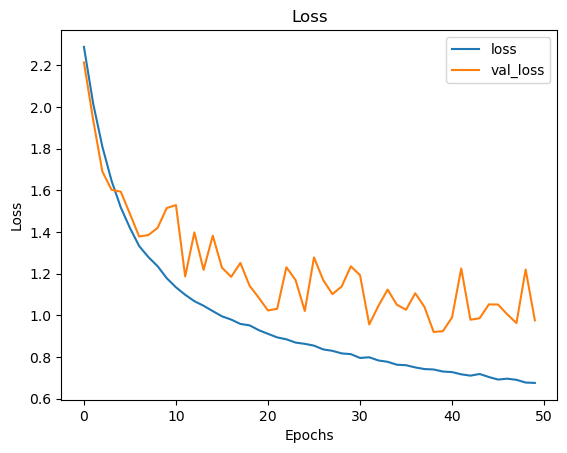

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

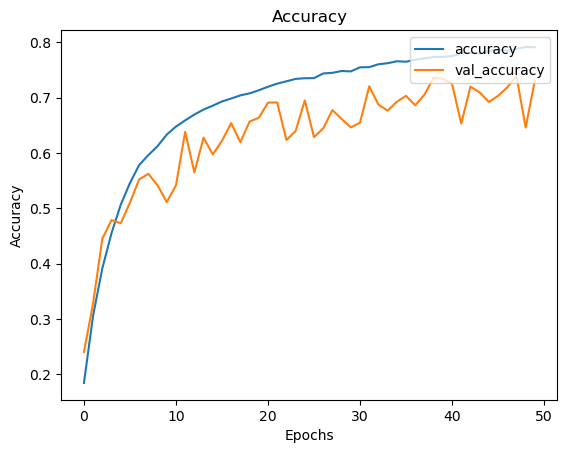

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')
plt.title('Accuracy')

In [84]:
model_seq.evaluate(x_test, y_test_oh, verbose=2)

814/814 - 1s - loss: 0.9753 - accuracy: 0.7315 - 1s/epoch - 2ms/step


[0.9753159284591675, 0.7314843535423279]

In [85]:
model_seq.save('mlp_model.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


# CNN neural network classifier

In [33]:
model_cnn = Sequential([
                        Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=x_train[0].shape),
                        MaxPooling2D((3, 3,)),
                        Conv2D(128, (3, 3), padding='same', activation='relu'),
                        MaxPooling2D((3, 3,)),
                        BatchNormalization(),
                        Conv2D(128, (3, 3), padding='same', activation='relu'),
                        MaxPooling2D((3, 3,)),
                        Dropout(0.3),
                        Flatten(),
                        Dense(256, activation='relu'),
                        Dropout(0.3),
                        Dense(10, activation='softmax')
])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 3, 3, 128)         512       
 chNormalization)                                                
                                                      

In [34]:
model_cnn.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [35]:
checkpoint_cnn = ModelCheckpoint(filepath='CNN', save_best_only=True,
                                 save_weights_only=True,
                                 save_freq=5000,
                                 monitor='val_acc',
                                 mode='max')
early_stop_cnn = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [32]:
# model_cnn = Sequential([
#                         Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=x_train[0].shape),
#                         MaxPooling2D((3, 3,)),
#                         Conv2D(32, (3, 3), padding='same', activation='relu'),
#                         MaxPooling2D((3, 3,)),
#                         BatchNormalization(),
#                         Conv2D(64, (3, 3), padding='same', activation='relu'),
#                         MaxPooling2D((3, 3,)),
#                         Dropout(0.5),
#                         Flatten(),
#                         Dense(64, activation='relu'),
#                         Dropout(0.5),
#                         Dense(10, activation='softmax')
# ])

# model_cnn.summary()

In [33]:
# model_cnn.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

In [34]:
# checkpoint_cnn = ModelCheckpoint(filepath='CNN', save_best_only=True,
#                                  save_weights_only=True,
#                                  save_freq=5000,
#                                  monitor='val_acc',
#                                  mode='max')
# early_stop_cnn = EarlyStopping(monitor='loss', patience=7, verbose=1)

In [36]:
history = model_cnn.fit(x_train,  y_train_oh,
                        callbacks=[checkpoint_cnn, early_stop_cnn],
                        batch_size=64, validation_data=(x_test, y_test_oh),
                        epochs=50)

Epoch 1/50
1145/1145 [==============================] - 55s 48ms/step - loss: 1.8074 - accuracy: 0.3716 - val_loss: 1.4315 - val_accuracy: 0.5596
Epoch 2/50
1145/1145 [==============================] - 56s 49ms/step - loss: 0.9705 - accuracy: 0.6856 - val_loss: 0.7673 - val_accuracy: 0.7717
Epoch 3/50
1145/1145 [==============================] - 57s 50ms/step - loss: 0.6824 - accuracy: 0.7900 - val_loss: 0.5655 - val_accuracy: 0.8331
Epoch 4/50
1145/1145 [==============================] - 59s 51ms/step - loss: 0.5656 - accuracy: 0.8264 - val_loss: 0.6341 - val_accuracy: 0.8125
Epoch 5/50
1145/1145 [==============================] - 59s 52ms/step - loss: 0.5080 - accuracy: 0.8447 - val_loss: 0.4717 - val_accuracy: 0.8611
Epoch 6/50
1145/1145 [==============================] - 59s 52ms/step - loss: 0.4694 - accuracy: 0.8579 - val_loss: 0.5083 - val_accuracy: 0.8547
Epoch 7/50
1145/1145 [==============================] - 57s 50ms/step - loss: 0.4424 - accuracy: 0.8658 - val_loss: 0.3983 -

1145/1145 [==============================] - 60s 53ms/step - loss: 0.1751 - accuracy: 0.9456 - val_loss: 0.3179 - val_accuracy: 0.9164
Epoch 46/50
1145/1145 [==============================] - 60s 52ms/step - loss: 0.1742 - accuracy: 0.9471 - val_loss: 0.3580 - val_accuracy: 0.9083
Epoch 47/50
1145/1145 [==============================] - 59s 52ms/step - loss: 0.1693 - accuracy: 0.9486 - val_loss: 0.3239 - val_accuracy: 0.9157
Epoch 48/50
1145/1145 [==============================] - 60s 52ms/step - loss: 0.1673 - accuracy: 0.9485 - val_loss: 0.3069 - val_accuracy: 0.9203
Epoch 49/50
1145/1145 [==============================] - 60s 52ms/step - loss: 0.1666 - accuracy: 0.9494 - val_loss: 0.3368 - val_accuracy: 0.9118
Epoch 50/50
1145/1145 [==============================] - 60s 52ms/step - loss: 0.1631 - accuracy: 0.9501 - val_loss: 0.3409 - val_accuracy: 0.9171


Text(0.5, 1.0, 'Loss')

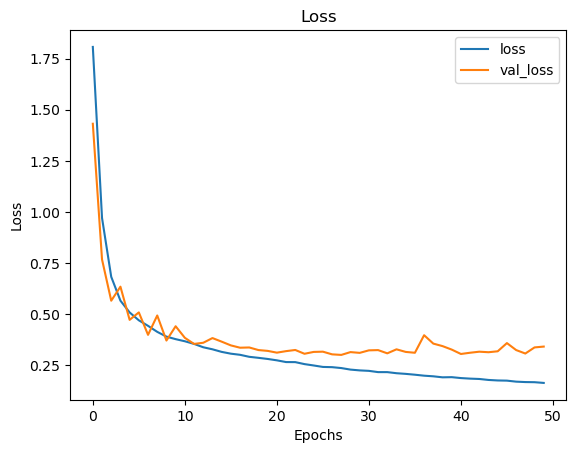

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

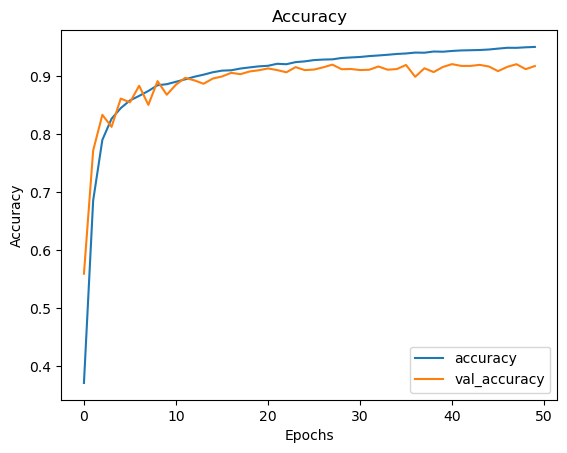

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.title('Accuracy')

In [39]:
model_cnn.evaluate(x_test, y_test_oh, verbose=2)

814/814 - 6s - loss: 0.3409 - accuracy: 0.9171 - 6s/epoch - 7ms/step


[0.3409345746040344, 0.9171404242515564]

In [40]:
model_cnn.save('cnn_model.h5')

# Get model predictions
* Load the best weights for the MLP and CNN models saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

# MLP Result

In [86]:
model_seq.load_weights('sequential')

1/1 [==============================] - 0s 15ms/step


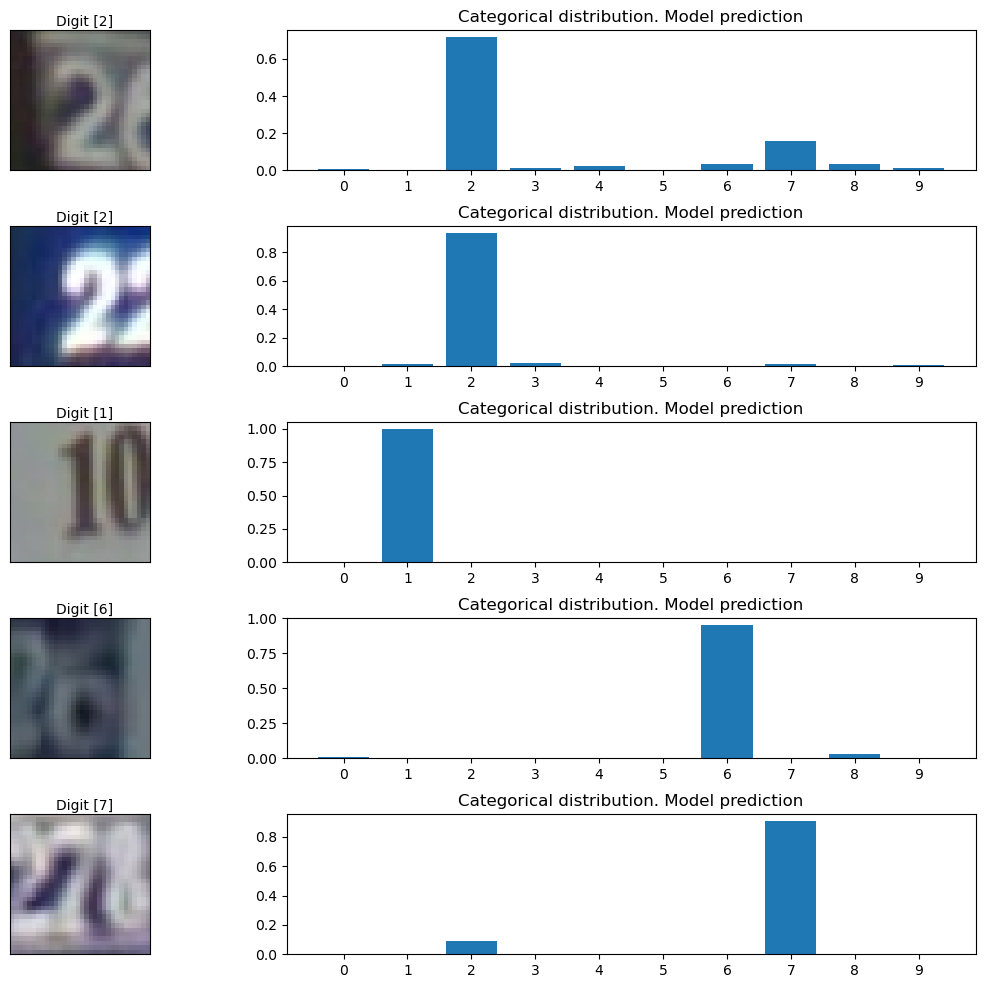

In [92]:
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_seq.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(0,10), prediction)
    axes[i, 1].set_xticks(np.arange(0,10))
    axes[i, 1].set_title("Categorical distribution. Model prediction")

plt.show()


814/814 [==============================] - 1s 1ms/step


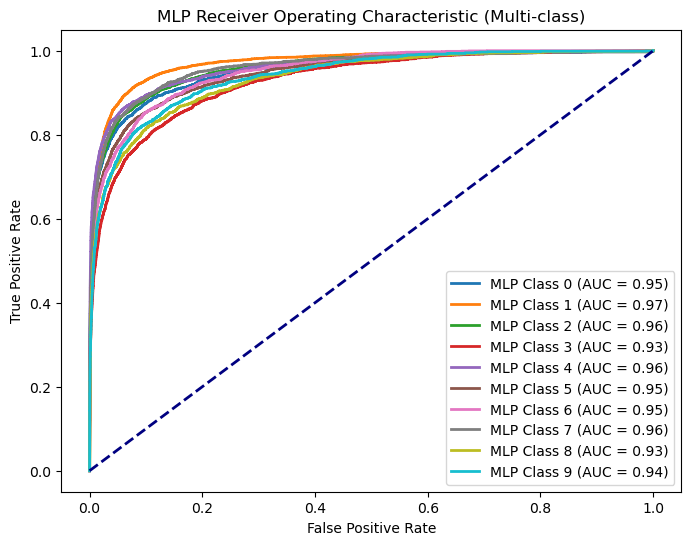

In [93]:
# Separate cell for MLP ROC curve
def plot_mlp_roc(model, x_test, y_test):
    # Predict probabilities
    y_probs = model.predict(x_test)
    
    # For binary classification
    if y_probs.shape[1] == 1:
        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'MLP ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('MLP Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()
        
    # For multi-class classification
    else:
        y_test_bin = label_binarize(y_test, classes=np.arange(y_probs.shape[1]))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(y_probs.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(y_probs.shape[1]):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'MLP Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('MLP Receiver Operating Characteristic (Multi-class)')
        plt.legend(loc='lower right')
        plt.show()

# Plot MLP ROC curve
plot_mlp_roc(model_seq, x_test, y_test)


## Fixed Confusion matrix (MLP) [amanat]

814/814 [==============================] - 1s 1ms/step


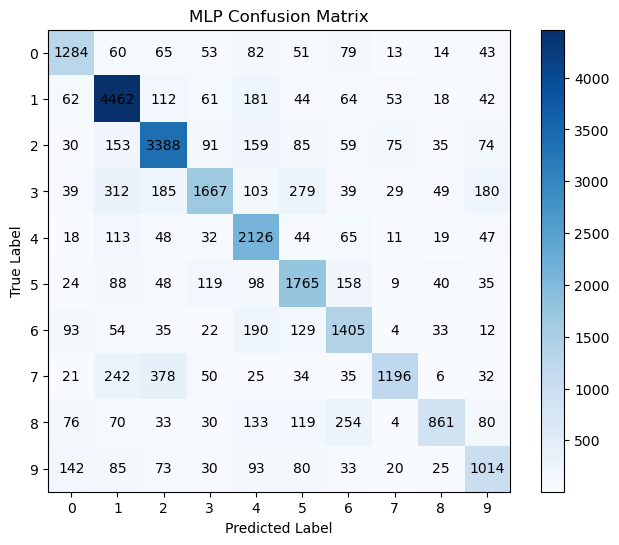

In [94]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_mlp_confusion(model, x_test, y_test):
    # Predict probabilities
    y_probs = model.predict(x_test)
    
    # Get the predicted labels
    y_pred = np.argmax(y_probs, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('MLP Confusion Matrix')
    plt.colorbar()
    
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Display the number in each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    
    plt.show()

# Assuming x_test and y_test are your test data and labels for the MLP model
plot_mlp_confusion(model_seq, x_test, y_test)

# CNN Result

1/1 [==============================] - 0s 16ms/step


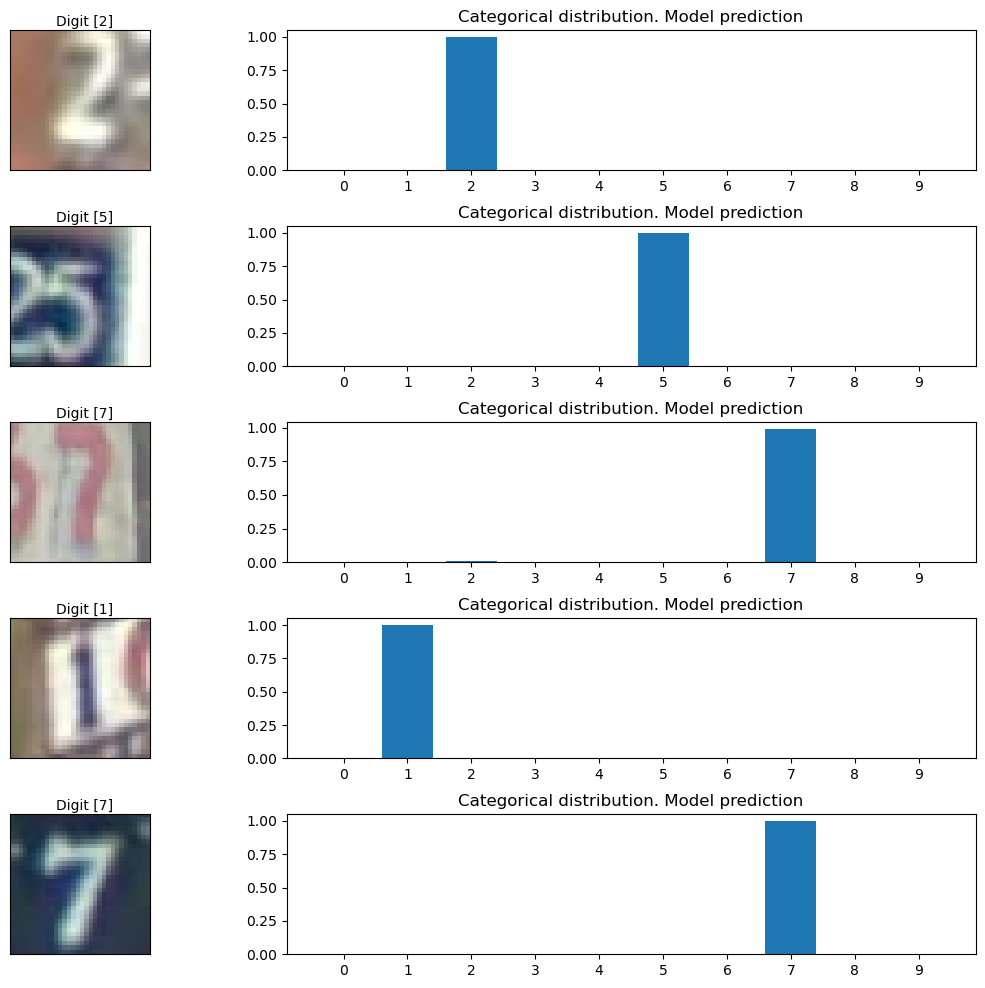

In [58]:
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(0,10), prediction)
    axes[i, 1].set_xticks(np.arange(0,10))
    axes[i, 1].set_title("Categorical distribution. Model prediction")

plt.show()


814/814 [==============================] - 5s 7ms/step


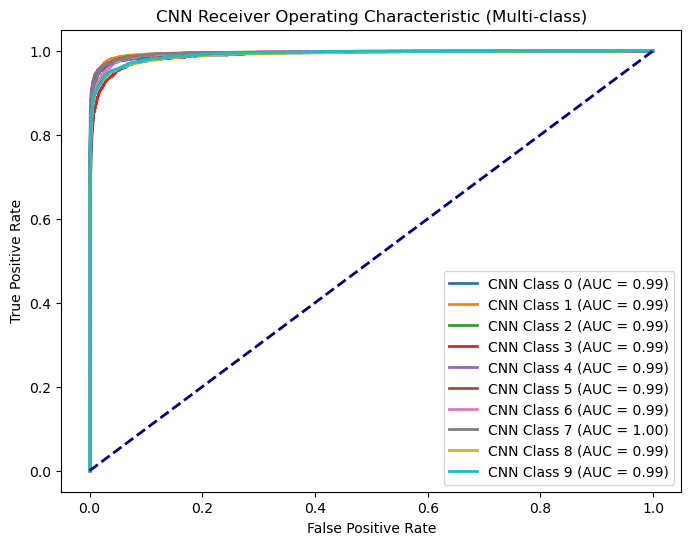

In [51]:
# Separate cell for CNN ROC curve
def plot_cnn_roc(model, x_test, y_test):
    # Predict probabilities
    y_probs = model.predict(x_test)
    
    # For binary classification
    if y_probs.shape[1] == 1:
        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CNN ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('CNN Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()
        
    # For multi-class classification
    else:
        y_test_bin = label_binarize(y_test, classes=np.arange(y_probs.shape[1]))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(y_probs.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(y_probs.shape[1]):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'CNN Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('CNN Receiver Operating Characteristic (Multi-class)')
        plt.legend(loc='lower right')
        plt.show()

# Plot CNN ROC curve
plot_cnn_roc(model_cnn, x_test, y_test)


## Fixed Confusion matrix (CNN) [amanat]

814/814 [==============================] - 6s 7ms/step


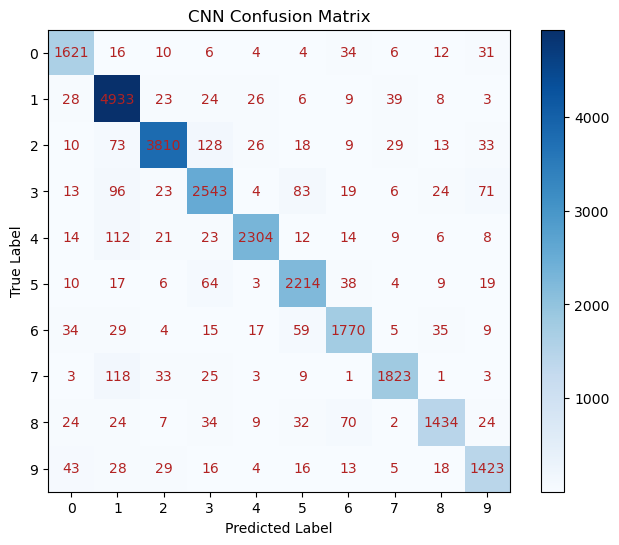

In [59]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_cnn_confusion(model, x_test, y_test):
    # # Predict probabilities
    # y_probs = model.predict(x_test)
    
    # # # Get the predicted labels
    # # y_pred = np.argmax(y_probs, axis=1)
    
    # # Compute confusion matrix
    # cm = confusion_matrix(y_test, y_pred)

        # Predict probabilities
    y_probs = model.predict(x_test)
    
    # Get the predicted labels
    y_pred = np.argmax(y_probs, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('CNN Confusion Matrix')
    plt.colorbar()
    
    classes = np.unique(y_test)
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Display the number in each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='firebrick')
    
    plt.show()

# Assuming x_test and y_test are your test data and labels for the CNN model
plot_cnn_confusion(model_cnn, x_test, y_test)


# Comparison Table

In [95]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have test datasets
# Use the one-hot encoded labels for evaluation
# If using y_test directly, convert it to one-hot encoded labels first

# Make predictions for loaded sequential model
predictions_seq = model_seq.predict(x_test)

# Convert predictions to binary values (0 or 1)
predictions_seq_binary = np.argmax(predictions_seq, axis=1)

# Calculate metrics for loaded sequential model
accuracy_seq = accuracy_score(np.argmax(y_test_oh, axis=1), predictions_seq_binary)
precision_seq = precision_score(np.argmax(y_test_oh, axis=1), predictions_seq_binary, average='weighted')
recall_seq = recall_score(np.argmax(y_test_oh, axis=1), predictions_seq_binary, average='weighted')
f1_seq = f1_score(np.argmax(y_test_oh, axis=1), predictions_seq_binary, average='weighted')

# Make predictions for loaded CNN model
predictions_cnn = model_cnn.predict(x_test)

# Convert predictions to binary values (0 or 1)
predictions_cnn_binary = np.argmax(predictions_cnn, axis=1)

# Calculate metrics for loaded CNN model
accuracy_cnn = accuracy_score(np.argmax(y_test_oh, axis=1), predictions_cnn_binary)
precision_cnn = precision_score(np.argmax(y_test_oh, axis=1), predictions_cnn_binary, average='weighted')
recall_cnn = recall_score(np.argmax(y_test_oh, axis=1), predictions_cnn_binary, average='weighted')
f1_cnn = f1_score(np.argmax(y_test_oh, axis=1), predictions_cnn_binary, average='weighted')

# Print or use the metrics as needed
print("CNN Model Metrics:")
print(f"Accuracy: {accuracy_cnn}")
print(f"Precision: {precision_cnn}")
print(f"Recall: {recall_cnn}")
print(f"F1 Score: {f1_cnn}")

print("\nMLP Model Metrics:")
print(f"Accuracy: {accuracy_seq}")
print(f"Precision: {precision_seq}")
print(f"Recall: {recall_seq}")
print(f"F1 Score: {f1_seq}")



814/814 [==============================] - 6s 7ms/step
CNN Model Metrics:
Accuracy: 0.917140442532268
Precision: 0.9180220843710489
Recall: 0.917140442532268
F1 Score: 0.9171200455129258

MLP Model Metrics:
Accuracy: 0.7363245236631838
Precision: 0.7425380700180296
Recall: 0.7363245236631838
F1 Score: 0.7326367676005914


# Interpretation starts from here

### CNN MODEL

[[4]]


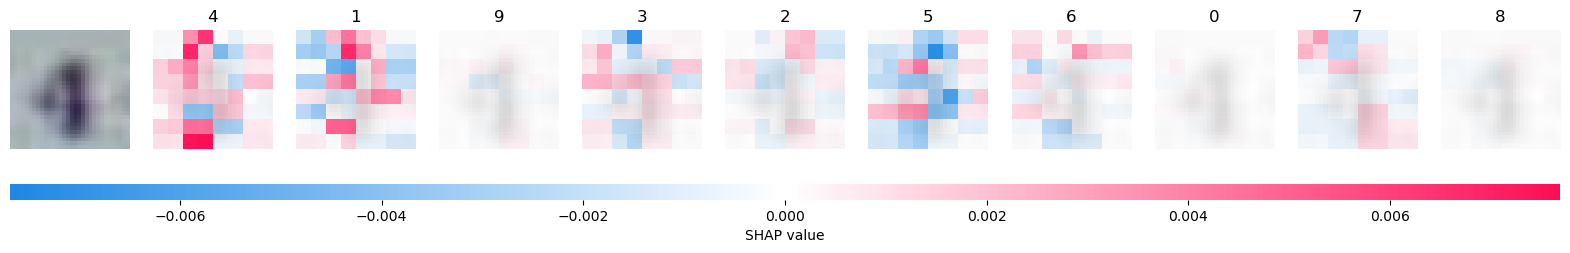

In [96]:
# import shap
# from tensorflow.keras.applications.resnet50 import preprocess_input

# Assuming cnn_model is your pre-trained model
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model_cnn(tmp)

# Choose or create an appropriate masker
masker = shap.maskers.Image(x_test[0], x_test[0].shape)

# Create explainer x_test[14:15] was taken by amanat you can chnage it
explainer = shap.Explainer(f, masker,output_names=[0,1,2,3,4,5,6,7,8,9])
shap_values = explainer(
    x_test[14:15], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:10]
)
print(y_test[14:15])
# Plot the SHAP values
shap.image_plot(shap_values)


### MLP MODEL

[[4]]


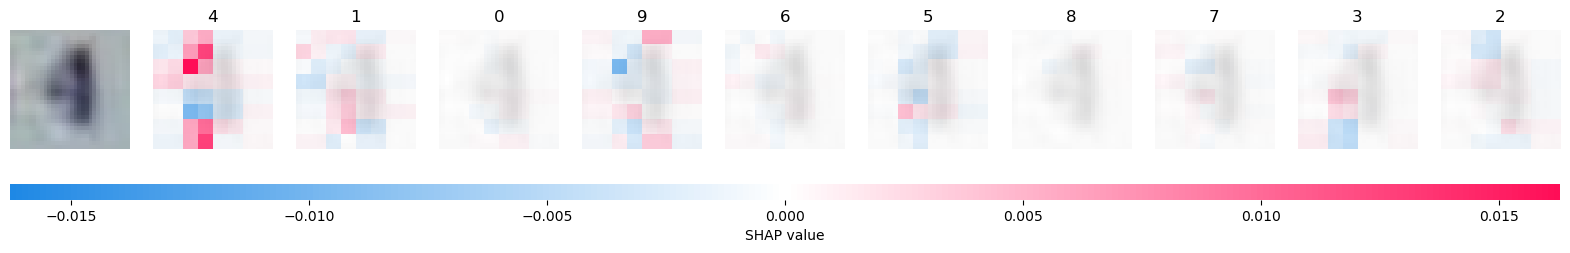

In [97]:
# import shap
# from tensorflow.keras.applications.resnet50 import preprocess_input

# Assuming cnn_model is your pre-trained model
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model_seq(tmp)


# Choose or create an appropriate masker
# For example, using "inpaint_telea" from SHAP
masker = shap.maskers.Image(x_test[0], x_test[0].shape)

# Create explainer 
explainer = shap.Explainer(f, masker,output_names=[0,1,2,3,4,5,6,7,8,9])
shap_values = explainer(
    x_test[15:16], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:10]
)
print(y_test[15:16])
# Plot the SHAP values
shap.image_plot(shap_values)


In [43]:
###for testing th code


# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Generate predictions using the CNN model
# y_pred_cnn = cnn_model.predict(x_test)
# y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# # Compute confusion matrix for CNN
# cnn_cm = confusion_matrix(y_test, y_pred_cnn_classes)

# # Plot confusion matrix for CNN
# plt.figure(figsize=(8, 8))
# sns.heatmap(cnn_cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=True, square=True,
#             xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.title("Confusion Matrix for CNN Model")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Generate predictions using the CNN model
# y_pred_cnn = cnn_model.predict(x_test)
# y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# # Flatten y_test if it's not already flattened
# y_test_flat = y_test.flatten()

# # Compute confusion matrix for CNN
# cnn_cm = confusion_matrix(y_test_flat, y_pred_cnn_classes)

# # Plot confusion matrix for CNN
# plt.figure(figsize=(8, 8))
# sns.heatmap(cnn_cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=True, square=True,
#             xticklabels=np.arange(10), yticklabels=np.arange(10))
# plt.title("Confusion Matrix for CNN Model")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()



In [44]:
### part of main code uncomment after done

# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import plot_model

# # Load the model from the saved file
# model_seq = load_model('mlp_model.h5')

# # Visualize the model
# plot_model(model_seq, to_file='mlp_model.png', show_shapes=True, show_layer_names=True)


In [45]:
### part of main code uncomment after done
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import plot_model

# # Load the CNN model from the saved file
# cnn_model = load_model('cnn_model.h5')

# # Visualize the CNN model
# plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)


In [46]:
# from tensorflow.keras.models import load_model

# Load Sequential Model
loaded_model_seq = load_model("mlp_model.h5")

# Load CNN Model
loaded_cnn_model = load_model("cnn_model.h5")


In [48]:
### part of main code uncomment after done

# # Data for plotting
# cnn_metrics = [accuracy_cnn, precision_cnn, recall_cnn, f1_cnn]

# # Bar plot for CNN Model
# fig, ax = plt.subplots()
# bar2 = ax.bar(index, cnn_metrics, bar_width, label='CNN Model')

# # Add labels, title, and legend
# ax.set_xlabel('Metrics')
# ax.set_ylabel('Scores')
# ax.set_title('Metrics for CNN Model')
# ax.set_xticks(index)
# ax.set_xticklabels(metrics_names)
# ax.legend()

# # Display the values on top of the bars
# for rect in bar2:
#     height = rect.get_height()
#     ax.annotate('%.3f' % height,
#                 xy=(rect.get_x() + rect.get_width() / 2, height),
#                 xytext=(0, 3),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center', va='bottom')

# # Show the plot
# plt.show()


In [53]:
### part of main code uncomment after done

# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import plot_model

# # Load the model from the saved file
# model_seq = load_model('mlp_model_keras.h5')

# # Visualize the model
# plot_model(model_seq, to_file='mlp_model_keras.png', show_shapes=True, show_layer_names=True)


In [54]:
### part of main code uncomment after done

# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import plot_model

# # Load the model from the saved file
# model_seq = load_model('cnn_model_keras.h5')

# # Visualize the model
# plot_model(model_seq, to_file='cnn_model_keras.png', show_shapes=True, show_layer_names=True)


In [58]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# # Generate predictions using the CNN model
# y_pred_cnn = cnn_model.predict(x_test)
# y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# # Compute confusion matrix for CNN
# cnn_cm = confusion_matrix(y_test, y_pred_cnn_classes)

# # Plot confusion matrix for CNN
# plt.figure(figsize=(8, 8))
# plt.imshow(cnn_cm, cmap=plt.cm.Blues)
# plt.title("Confusion Matrix for CNN Model")
# plt.colorbar()
# plt.xticks(range(len(np.unique(y_test))))
# plt.yticks(range(len(np.unique(y_test))))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


In [60]:
# # Generate predictions using the MLP model
# y_pred_mlp = mlp_model.predict(x_test)
# y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)

# # Compute confusion matrix for MLP
# mlp_cm = confusion_matrix(y_test, y_pred_mlp_classes)

# # Plot confusion matrix for MLP
# plt.figure(figsize=(8, 8))
# plt.imshow(mlp_cm, cmap=plt.cm.Blues)
# plt.title("Confusion Matrix for MLP Model")
# plt.colorbar()
# plt.xticks(range(len(np.unique(y_test))))
# plt.yticks(range(len(np.unique(y_test))))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()


In [62]:
### this cell is added for testing confusionmatrix
#this one is without any number so ignore
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# # Generate predictions using the CNN model
# y_pred_cnn = cnn_model.predict(x_test)
# y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# # Compute confusion matrix for CNN
# cnn_cm = confusion_matrix(y_test, y_pred_cnn_classes)

# # Plot confusion matrix for CNN
# plt.figure(figsize=(8, 8))
# plt.imshow(cnn_cm, cmap=plt.cm.Blues)
# plt.title("Confusion Matrix for CNN Model")
# plt.colorbar()
# plt.xticks(range(len(np.unique(y_test))))
# plt.yticks(range(len(np.unique(y_test))))
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()
